In [158]:
!pip install -q seaborn

In [159]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns

In [160]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, models

print(tf.__version__)

2.8.2


In [161]:
# Ocitavanje kategorija
column_names_categories = ['code','parent-code','name']
categories_data = pd.read_csv('categories.csv', names = column_names_categories, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
categories_data.head()

,code,parent-code,name
0,0,A,Other
1,1,B,Other
2,2,B,Auto Insurance
3,3,B,Auto Leasing
4,4,B,Gas & Fuel


In [162]:
def preproccess_data(data_url, labels_url = None):
  column_names_data = ['id', 'beneficiary-name', 'date', 'direction', 'amount', 'description', 'currency', 'mcc', 'kind']
  column_names_labels = ['id', 'label']

  dataset = pd.read_csv(data_url, names = column_names_data, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)

  #amount
  dataset['amount'] = dataset['amount'].map(lambda x : float(x.replace(",", "")))
  
  #date => day, month, year
  dataset[["day", "month", "year"]] = dataset["date"].str.split("/", expand=True)
  del dataset['date']
  dataset = dataset.astype({"day" : int, "month" : int, "year" : int})
  
  #kind
  dataset['kind'] = dataset['kind'].fillna('U')
  kind_dummy = pd.get_dummies(dataset['kind'], prefix='', prefix_sep='')
  del dataset['kind']
  dataset = pd.concat([dataset, kind_dummy], axis=1, join='inner')
  
  #direction
  direction_dummy = pd.get_dummies(dataset['direction'], prefix='', prefix_sep='')
  del dataset['direction']
  dataset = pd.concat([dataset, direction_dummy], axis=1, join='inner')
  
  # mcc
  dataset['mcc'] = dataset['mcc'].fillna('0')
  dataset = dataset.astype({"mcc" : int})
  mcc_dummy = pd.get_dummies(dataset['mcc'], prefix='', prefix_sep='')
  del dataset['mcc']
  dataset = pd.concat([dataset, mcc_dummy], axis=1, join='inner')
  
  # description
  del dataset['description']
  
  # beneficiary name
  del dataset['beneficiary-name']
  
  # currency
  del dataset['currency']
  
  # id
  del dataset['id']

  if labels_url != None:
    dataset_labels = pd.read_csv(labels_url, names = column_names_labels, na_values = '?', comment='\t', sep = ',' , skipinitialspace=True, header=0)
    dataset_labels.pop('id')
    # add label column
    dataset['label'] = dataset_labels
  
  return dataset

In [163]:
dataset = preproccess_data("transactions.csv", "transactions_labels.csv")
dataset.shape

(1303, 41)

In [164]:
X = dataset.drop('label', axis = 1)
y = dataset[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [165]:
def build_model(dataset):
  # TODO , nije lepo numerisano
  num_classes = 107 
  # num_classes = categories_data['code'].max() + 1
  num_parameters = dataset.shape[1] - 1

  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim= num_parameters))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [166]:
model = build_model(dataset)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 256)               10496     
                                                                 
 dense_72 (Dense)            (None, 256)               65792     
                                                                 
 dense_73 (Dense)            (None, 512)               131584    
                                                                 
 dense_74 (Dense)            (None, 512)               262656    
                                                                 
 dense_75 (Dense)            (None, 107)               54891     
                                                                 
Total params: 525,419
Trainable params: 525,419
Non-trainable params: 0
_________________________________________________________________


In [167]:
num_classes = categories_data['code'].max() + 1
epochs = 500
batch_size = 32

train_labels_cat = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels_cat = tf.keras.utils.to_categorical(y_test, num_classes)


history = model.fit(X_train, train_labels_cat, epochs = epochs, batch_size = batch_size)

Epoch 1/500
31/31 [==============================] - 2s 16ms/step - loss: 40.2195 - accuracy: 0.0931
Epoch 2/500
31/31 [==============================] - 0s 15ms/step - loss: 4.7600 - accuracy: 0.2528
Epoch 3/500
31/31 [==============================] - 0s 14ms/step - loss: 3.4638 - accuracy: 0.2784
Epoch 4/500
31/31 [==============================] - 0s 14ms/step - loss: 3.2056 - accuracy: 0.3173
Epoch 5/500
31/31 [==============================] - 0s 14ms/step - loss: 3.1427 - accuracy: 0.3173
Epoch 6/500
31/31 [==============================] - 0s 16ms/step - loss: 3.0287 - accuracy: 0.3173
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 2.8703 - accuracy: 0.3296
Epoch 8/500
31/31 [==============================] - 0s 16ms/step - loss: 2.8451 - accuracy: 0.3204
Epoch 9/500
31/31 [==============================] - 0s 14ms/step - loss: 2.8055 - accuracy: 0.3357
Epoch 10/500
31/31 [==============================] - 0s 15ms/step - loss: 2.7610 - accuracy: 0.331

11/11 - 0s - loss: 0.6178 - accuracy: 0.8129 - 349ms/epoch - 32ms/step


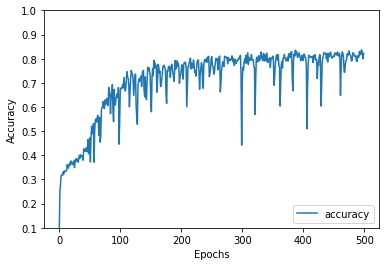

In [169]:
# Evaluation

plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

In [170]:
print(f'Preciznost na test skupu je: {test_acc}')

Preciznost na test skupu je: 0.8128834366798401


In [171]:
predictions = list(map(lambda x : np.argmax(x), list(model.predict(X_test))))
real_values = list(y_test['label'])

In [172]:
for i in range(len(predictions)):
   print(f'Projektovana vrednost je {predictions[i]} , a stvarna vrednost je {real_values[i]}')

Projektovana vrednost je 13 , a stvarna vrednost je 77
Projektovana vrednost je 47 , a stvarna vrednost je 10
Projektovana vrednost je 26 , a stvarna vrednost je 26
Projektovana vrednost je 105 , a stvarna vrednost je 105
Projektovana vrednost je 39 , a stvarna vrednost je 39
Projektovana vrednost je 11 , a stvarna vrednost je 11
Projektovana vrednost je 39 , a stvarna vrednost je 39
Projektovana vrednost je 39 , a stvarna vrednost je 39
Projektovana vrednost je 48 , a stvarna vrednost je 48
Projektovana vrednost je 53 , a stvarna vrednost je 4
Projektovana vrednost je 105 , a stvarna vrednost je 105
Projektovana vrednost je 90 , a stvarna vrednost je 44
Projektovana vrednost je 56 , a stvarna vrednost je 56
Projektovana vrednost je 103 , a stvarna vrednost je 103
Projektovana vrednost je 11 , a stvarna vrednost je 20
Projektovana vrednost je 17 , a stvarna vrednost je 17
Projektovana vrednost je 90 , a stvarna vrednost je 90
Projektovana vrednost je 11 , a stvarna vrednost je 11
Proje